<a href="https://colab.research.google.com/github/Niloofark/Income-Prediction-Supervised-Learning-/blob/main/Final__HDSI_AgriSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Start by installing the necessary Google Cloud libraries in your Google Colab env
!pip install --upgrade --quiet gcsfs google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
from google.colab import drive
import os

In [ ]:
auth.authenticate_user()
drive.mount('/content/drive', force_remount=True)

## Shared Drive in a Google Workspace
directory_path = '/content/drive/My Drive/HDSI/'

## Initialize the Google Cloud Storage client.
from google.cloud import storage
client = storage.Client(project='HDSI-Agri-Datathon-2024')
bucket_name = 'hdsi-agri-prompt-data'

## Access the specified bucket
bucket = client.bucket(bucket_name)

## List all blobs (files and folders) in the bucket
blobs = list(bucket.list_blobs())


## Initialize variables to count and store folder names and file types
folders = set()
file_types = set()
blob_count = 0


## Loop through all blobs to gather folder names and file types
for blob in blobs:
    blob_name = blob.name

    ## Check if it's a folder (by convention, ends with '/')
    if blob_name.endswith('/'):
        folders.add(blob_name)

    else:
        ## Capture file type
        file_extension = blob_name.split('.')[-1] if '.' in blob_name else 'Unknown'
        file_types.add(file_extension)
    blob_count += 1


## list the folders
print("Folders in the bucket:")
for folder in folders:
    print(f" - {folder}")

## Show the file types of the first 5 files (skip folders)
print("\nFirst 5 file types:")

counter = 0
for blob in blobs:
    if not blob.name.endswith('/') and counter < 5:
        file_name = blob.name
        file_extension = file_name.split('.')[-1] if '.' in file_name else 'Unknown'
        print(f"File name: {file_name}, File type: {file_extension}")
        counter += 1


## Total count of blobs
print(f"\nTotal number of blobs in the bucket: {blob_count}")

## Print the unique file types found
print(f"\nFile types in the bucket: {', '.join(file_types)}")

Mounted at /content/drive
Folders in the bucket:
 - HDSI_AGRI_Prompt_3/
 - HDSI_AGRI_Prompt_1/
 - HDSI_AGRI_Prompt_2/
 - HDSI_AGRI_Prompt_1/cropland_images/

First 5 file types:
File name: HDSI_AGRI_Prompt_1/NDVI_images/Adams_2001_01_NDVI.tif, File type: tif
File name: HDSI_AGRI_Prompt_1/NDVI_images/Adams_2001_02_NDVI.tif, File type: tif
File name: HDSI_AGRI_Prompt_1/NDVI_images/Adams_2001_03_NDVI.tif, File type: tif
File name: HDSI_AGRI_Prompt_1/NDVI_images/Adams_2001_04_NDVI.tif, File type: tif
File name: HDSI_AGRI_Prompt_1/NDVI_images/Adams_2001_05_NDVI.tif, File type: tif

Total number of blobs in the bucket: 14974

File types in the bucket: tif, csv, dbf, xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from scipy.stats import ttest_ind
import plotly.express as px
import plotly.io as pio

In [ ]:
# Load Data
county_data = pd.read_csv('/content/prompt2_demos_landtotals_county.csv', low_memory=False)
sales_data = pd.read_csv('/content/prompt2_prompt3_sales.csv', low_memory=False)
state_level_data = pd.read_csv('/content/state_level_2002_2007_2012_2017_2022.xlsx - Sheet1.csv')

In [ ]:
# Describe datasets
print(county_data.info())
print(sales_data.info())
print(state_level_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18765 entries, 0 to 18764
Columns: 162 entries, STATE_FIPS_CODE to PRODUCERS_YEARS_ON_PRESENT_OPERATION_LT_3_YEARS_NUMBER_OF_PRODUCERS
dtypes: float64(127), int64(4), object(31)
memory usage: 23.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18746 entries, 0 to 18745
Columns: 1481 entries, STATE_FIPS_CODE to WILD_RICE_PRODUCTION_MEASURED_IN_CWT
dtypes: float64(746), int64(4), object(731)
memory usage: 211.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                2346 non-null   int64  
 1   State ANSI                          2346 non-null   int64  
 2   GEO                                 1046 non-null   object 
 3   Data Item                           2346 non-null   object 
 4   NOT SPECIFIED 

In [ ]:
# Define dataframes
dataframes = [county_data, sales_data, state_level_data]  # List of dataframes
df_names = ['county_data', 'sales_data', 'state_level_data']  # Names of dataframes for printing

# Iterate through each dataframe and count null values
for i, df in enumerate(dataframes, start=1):
    print(f"Null values in {df_names[i-1]}:")

    # Null values per column
    null_counts = df.isnull().sum()
    print(null_counts)

    # Total null values in the dataset
    total_null = df.isnull().sum().sum()
    print(f"Total null values in {df_names[i-1]}: {total_null}\n")

Null values in county_data:
STATE_FIPS_CODE                                                              0
COUNTY_CODE                                                                  0
YEAR                                                                         0
AG_LAND_CROPLAND_HARVESTED_ACRES                                            19
AG_LAND_CROPLAND_HARVESTED_ACRES_ON_OPERATIONS_WITH_TENURE_FULL_OWNER       36
                                                                         ...  
PRODUCERS_YEARS_ON_PRESENT_OPERATION_3_TO_4_YEARS_NUMBER_OF_PRODUCERS    12560
PRODUCERS_YEARS_ON_PRESENT_OPERATION_5_TO_9_YEARS_NUMBER_OF_PRODUCERS    12525
PRODUCERS_YEARS_ON_PRESENT_OPERATION_AVG_MEASURED_IN_YEARS               12508
PRODUCERS_YEARS_ON_PRESENT_OPERATION_GE_10_YEARS_NUMBER_OF_PRODUCERS     12512
PRODUCERS_YEARS_ON_PRESENT_OPERATION_LT_3_YEARS_NUMBER_OF_PRODUCERS      12580
Length: 162, dtype: int64
Total null values in county_data: 1536161

Null values in sales_data:
STATE_F

# **Spatiotemporal Trends in Farmer Age:**

## **1. How has the average age of farmers evolved over time across county, states, and nation in the United States, from 1997 onwards?**

### **Data Preprocessing and Cleaning:**

In [ ]:
# Unique values of year
county_data['YEAR'].unique()

array([1997, 2002, 2007, 2012, 2017, 2022])

In [ ]:
# Create flags for missing data
county_data['Missing_Operator_Age'] = county_data['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].isnull().astype(int)
county_data['Missing_Producer_Age'] = county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'].isnull().astype(int)

# Summarize the missing data by COUNTY_CODE and calculate the total number of missing values
missing_summary_by_county = county_data.groupby('COUNTY_CODE')[['Missing_Operator_Age', 'Missing_Producer_Age']].sum().reset_index()

# Add a total column for missing values
missing_summary_by_county['Total_Missing'] = missing_summary_by_county['Missing_Operator_Age'] + missing_summary_by_county['Missing_Producer_Age']

# Print the missing data summary with totals
print(missing_summary_by_county)


     COUNTY_CODE  Missing_Operator_Age  Missing_Producer_Age  Total_Missing
0              1                    96                   192            288
1              3                    98                   196            294
2              5                    95                   190            285
3              6                     2                     4              6
4              7                    94                   188            282
..           ...                   ...                   ...            ...
268          510                     2                     4              6
269          550                     2                     4              6
270          800                     2                     4              6
271          810                     2                     4              6
272          999                   102                   203            305

[273 rows x 4 columns]


In [ ]:
# Check for null values in the two columns
null_values_check = county_data[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].isnull().sum()
print(null_values_check)

OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS     6257
PRODUCERS_AGE_AVG_MEASURED_IN_YEARS              12508
dtype: int64


In [ ]:
len(county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'])

18765

In [ ]:
# Convert the columns to numeric, coercing any non-numeric values to NaN)
county_data['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'] = pd.to_numeric(county_data['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'], errors='coerce')
county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'] = pd.to_numeric(county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'], errors='coerce')

# Group by 'STATE_FIPS_CODE' and 'COUNTY_CODE' to calculate the mean for principals and producers
mean_operators_age = county_data.groupby(['STATE_FIPS_CODE', 'COUNTY_CODE'])['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].transform('mean')
mean_producers_age = county_data.groupby(['STATE_FIPS_CODE', 'COUNTY_CODE'])['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'].transform('mean')


# Fill missing values with the mean age within the same state and county
county_data['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'] = county_data['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].fillna(mean_operators_age)
county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'] = county_data['PRODUCERS_AGE_AVG_MEASURED_IN_YEARS'].fillna(mean_producers_age)

# Check if the mean replacement was successful and if null values remain
print(county_data[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].isnull().sum())


OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS    2
PRODUCERS_AGE_AVG_MEASURED_IN_YEARS              5
dtype: int64


The null/missing values are replaced by mean, median and interpolate but the results were significantly the same for all cases. We cannot remove the missing values at all, because they are substantial: 1/3 of Principals and 2/3 Producers.

### **1.1 County-Level Average Age for both Principals and Producers:**

In [ ]:
# Group by 'YEAR', 'STATE_FIPS_CODE', and 'COUNTY_CODE' to calculate the average age for both principals and producers
county_average_age_per_year = county_data.groupby(['STATE_FIPS_CODE', 'COUNTY_CODE', 'YEAR'])[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].mean().reset_index()

# Sort by STATE_FIPS_CODE, COUNTY_CODE, and then by YEAR
county_average_age_per_year_sorted = county_average_age_per_year.sort_values(by=['STATE_FIPS_CODE', 'COUNTY_CODE', 'YEAR']).round(2)

# Set display options for better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Print the DataFrame with columns properly aligned
print(county_average_age_per_year_sorted.head(10))


   STATE_FIPS_CODE  COUNTY_CODE  YEAR  OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS  PRODUCERS_AGE_AVG_MEASURED_IN_YEARS
0                1            1  1997                                          57.40                                56.05
1                1            1  2002                                          58.10                                56.05
2                1            1  2007                                          56.20                                56.05
3                1            1  2012                                          58.20                                56.05
4                1            1  2017                                          57.48                                57.00
5                1            1  2022                                          57.48                                55.10
6                1            3  1997                                          56.10                                59.25
7                1      

### **1.2 State-Level Average Age for both Principals and Producers:**

In [ ]:
# Group by 'YEAR' and 'STATE_FIPS_CODE' to calculate the average age for each state for both principals and producers
state_average_age_per_year = county_data.groupby(['STATE_FIPS_CODE', 'YEAR'])[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].mean().round(2).reset_index()

# Sort by STATE_FIPS_CODE and YEAR
state_average_age_per_year_sorted = state_average_age_per_year.sort_values(by=['STATE_FIPS_CODE', 'YEAR'])

# Set display options for better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Print the DataFrame
print(state_average_age_per_year_sorted.head(10))


   STATE_FIPS_CODE  YEAR  OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS  PRODUCERS_AGE_AVG_MEASURED_IN_YEARS
0                1  1997                                          55.21                                58.73
1                1  2002                                          57.06                                58.73
2                1  2007                                          57.95                                58.73
3                1  2012                                          59.62                                58.73
4                1  2017                                          57.46                                58.42
5                1  2022                                          57.46                                59.03
6                2  1997                                          52.47                                55.21
7                2  2002                                          54.28                                55.21
8                2 

### **1.3 National Average Age for both Principals and Producers:**

In [ ]:
# Group by 'YEAR' to calculate the national average age
national_average_age_per_year = county_data.groupby('YEAR')['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].mean().round(2).reset_index()
print(national_average_age_per_year.head(10))

   YEAR  OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS
0  1997                                          54.20
1  2002                                          55.47
2  2007                                          57.24
3  2012                                          58.51
4  2017                                          56.36
5  2022                                          56.36


In [ ]:
# Top 5 oldest states based on their farmers' average age:

# Step 1: Calculate the overall average age for each state (both principals and producers)
state_avg_age = state_average_age_per_year_sorted.groupby('STATE_FIPS_CODE')[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].mean().reset_index()

# Step 2: Calculate the combined average age (mean of principals and producers)
state_avg_age['Combined_Avg_Age'] = state_avg_age[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', 'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].mean(axis=1)

# Step 3: Select the top 5 oldest states based on the combined average age
oldest_states = state_avg_age.nlargest(5, 'Combined_Avg_Age')['STATE_FIPS_CODE']

# Step 4: Filter the original data to include only these 5 states
oldest_states_data = state_average_age_per_year_sorted[state_average_age_per_year_sorted['STATE_FIPS_CODE'].isin(oldest_states)]
oldest_states_data

,STATE_FIPS_CODE,YEAR,OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS,PRODUCERS_AGE_AVG_MEASURED_IN_YEARS
12,4,1997,55.89,59.48
13,4,2002,55.74,59.48
14,4,2007,58.41,59.48
15,4,2012,61.07,59.48
16,4,2017,57.78,59.52
17,4,2022,57.78,59.44
60,15,1997,55.04,60.19
61,15,2002,56.32,60.19
62,15,2007,58.78,60.19
63,15,2012,60.46,60.19


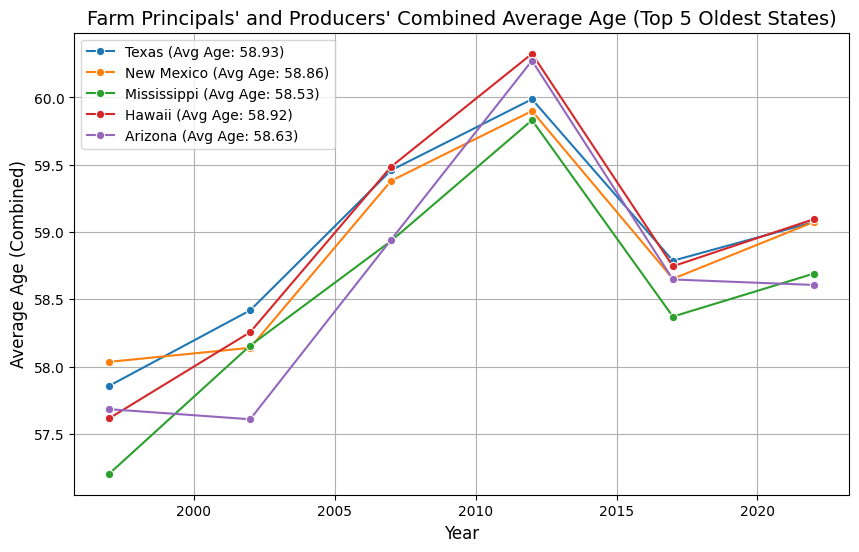

In [ ]:
# Farm Principals' and Producers' Combined Average Age (Top 5 Oldest States):

# Calculate the combined average age for both principals and producers
county_data['Combined_Average_Age'] = county_data[['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS',
                                                   'PRODUCERS_AGE_AVG_MEASURED_IN_YEARS']].mean(axis=1)

# Group by state and year to calculate the combined average age for plotting
state_average_age_per_year_combined = county_data.groupby(['STATE_FIPS_CODE', 'YEAR'])['Combined_Average_Age'].mean().reset_index()

# Overall average age per state (ignoring year) - for reference or legend
state_avg_ages_combined = state_average_age_per_year_combined.groupby('STATE_FIPS_CODE')['Combined_Average_Age'].mean().round(2)

# FIPS to State dictionary with some examples (expand as needed)
fips_to_state = {
    48: 'Texas',
    35: 'New Mexico',
    28: 'Mississippi',
    15: 'Hawaii',
    4: 'Arizona'
}

# Example of the oldest states (can be dynamically selected as needed)
oldest_states = [48, 35, 28, 15, 4]  # List of the top 5 oldest states based on the FIPS codes

# Set up the plot
plt.figure(figsize=(10, 6))

# Loop for plotting combined trends for each state
for state_code in oldest_states:
    # Filter data for the current state
    state_data = state_average_age_per_year_combined[state_average_age_per_year_combined['STATE_FIPS_CODE'] == state_code]

    # Fetch state name or fallback to 'State {state_code}'
    state_name = fips_to_state.get(state_code, f'State {state_code}')

    # Fetch average age for this state
    avg_age = state_avg_ages_combined.get(state_code, None)

    # Plot the state's data if the average age exists
    if avg_age is not None:
        sns.lineplot(data=state_data,
                     x='YEAR',
                     y='Combined_Average_Age',
                     marker='o',
                     label=f'{state_name} (Avg Age: {avg_age})')

# Customize the plot
plt.title("Farm Principals' and Producers' Combined Average Age (Top 5 Oldest States)", fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Age (Combined)', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:


# Define the columns related to farm sales
farm_sales_columns = [
    'FARM SALES: (LESS THAN 1,000 $)', 'FARM SALES: (1,000 TO 2,499 $)',
    'FARM SALES: (2,500 TO 4,999 $)', 'FARM SALES: (5,000 TO 9,999 $)',
    'FARM SALES: (10,000 TO 24,999 $)', 'FARM SALES: (25,000 TO 49,999 $)',
    'FARM SALES: (50,000 TO 99,999 $)', 'FARM SALES: (100,000 TO 249,999 $)',
    'FARM SALES: (250,000 TO 499,999 $)', 'FARM SALES: (500,000 TO 999,999 $)',
    'FARM SALES: (1,000,000 OR MORE $)'
]

# Convert columns to numeric, ignoring non-numeric errors
state_level_data[farm_sales_columns] = state_level_data[farm_sales_columns].apply(pd.to_numeric, errors='coerce')

# Calculate the total sales for each row by summing up all farm sales columns
state_level_data['Total Sales'] = state_level_data[farm_sales_columns].sum(axis=1)

# Group by state and calculate total sales per state
state_sales = state_level_data.groupby('GEO')['Total Sales'].sum().reset_index()

# Filter out "United States" from the GEO column
state_sales_filtered = state_sales[state_sales['GEO'] != 'United States']

# Sort the states by total sales, get the top 5 and bottom 5
highest_sales_states_filtered = state_sales_filtered.nlargest(5, 'Total Sales')
lowest_sales_states_filtered = state_sales_filtered.nsmallest(5, 'Total Sales')

# Display the results
print("Highest Sales States (Excluding United States):")
print(highest_sales_states_filtered)

print("\nLowest Sales States (Excluding United States):")
print(lowest_sales_states_filtered)


Highest Sales States (Excluding United States):
         GEO  Total Sales
42     Texas     477617.0
24  Missouri     215840.9
14      Iowa     184699.8
16  Kentucky     173003.0
35  Oklahoma     171099.2

Lowest Sales States (Excluding United States):
              GEO  Total Sales
1          Alaska       2517.2
38   Rhode Island       3294.7
7        Delaware       6159.0
27         Nevada       7373.9
28  New Hampshire       8739.2


In [ ]:
highest_sales_df = pd.DataFrame({
    'GEO': ['Texas', 'Missouri', 'Iowa', 'Kentucky', 'Oklahoma'],
    'Total Sales': [477617.0, 215840.9, 184699.8, 173003.0, 171099.2]
})

lowest_sales_df = pd.DataFrame({
    'GEO': ['Alaska', 'Rhode Island', 'Delaware', 'Nevada', 'New Hampshire'],
    'Total Sales': [2517.2, 3294.7, 6159.0, 7373.9, 8739.2]
})

# Display the dataframes
print("Highest Sales States (Excluding United States):")
print(highest_sales_df)

print("\nLowest Sales States (Excluding United States):")
print(lowest_sales_df)


Highest Sales States (Excluding United States):
        GEO  Total Sales
0     Texas     477617.0
1  Missouri     215840.9
2      Iowa     184699.8
3  Kentucky     173003.0
4  Oklahoma     171099.2

Lowest Sales States (Excluding United States):
             GEO  Total Sales
0         Alaska       2517.2
1   Rhode Island       3294.7
2       Delaware       6159.0
3         Nevada       7373.9
4  New Hampshire       8739.2


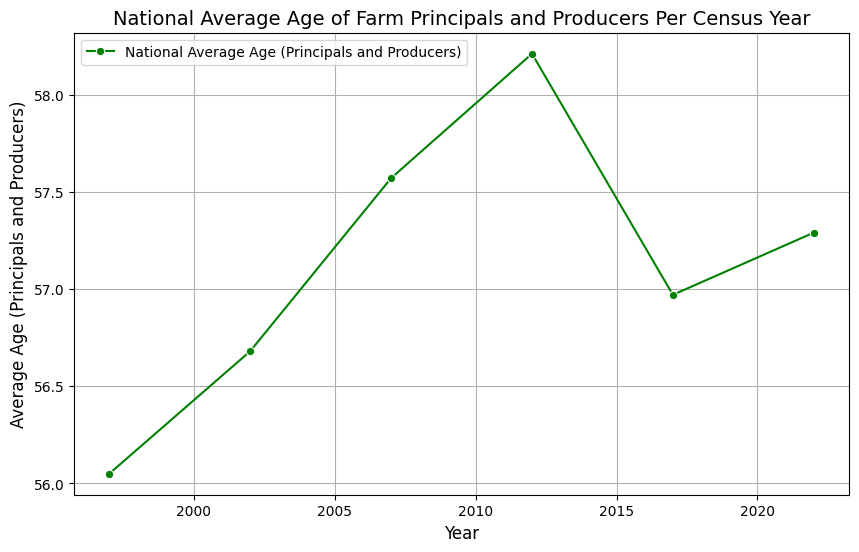

In [ ]:
# Plot the national average age trend for both principals and producers
national_average_age_per_year = county_data.groupby('YEAR')['Combined_Average_Age'].mean().round(2).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=national_average_age_per_year,
             x='YEAR',
             y='Combined_Average_Age',
             marker='o',
             color='green',
             label='National Average Age (Principals and Producers)')
plt.title("National Average Age of Farm Principals and Producers Per Census Year", fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Age (Principals and Producers)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


### **2. Are there statistically significant regional deviations from the national trend? From the census years of 2002-2022? For instance, are certain counties experiencing a more rapid aging of their farming population or a more pronounced decline in average age? Or which regions show a stabilization of age demographics compared to the national trend?**

### **2.1 Merge National and State Trends and Calculate the Deviations:**

In [ ]:
# Merge state trends with national trends on 'YEAR'
merged_trends = pd.merge(state_average_age_per_year_combined, national_average_age_per_year, on='YEAR', suffixes=('_state', '_national')).round(2)

# Calculate deviation for each state from the national trend
merged_trends['Deviation'] = merged_trends['Combined_Average_Age_state'] - merged_trends['Combined_Average_Age_national']

# Check the merged DataFrame
print(merged_trends.head())

   STATE_FIPS_CODE  YEAR  Combined_Average_Age_state  Combined_Average_Age_national  Deviation
0                1  1997                       56.97                          56.05       0.92
1                1  2002                       57.89                          56.68       1.21
2                1  2007                       58.34                          57.57       0.77
3                1  2012                       59.17                          58.21       0.96
4                1  2017                       57.94                          56.97       0.97


### **2.2 Perform Statistical Testing (t-test):**

In [ ]:
# Example: Perform t-test for a specific state (e.g., FIPS code 48 for Texas)
state_code = 48  # Texas
state_ages = merged_trends[merged_trends['STATE_FIPS_CODE'] == state_code]['Combined_Average_Age_state']
national_ages = merged_trends['Combined_Average_Age_national']

# Perform the t-test
t_stat, p_value = ttest_ind(state_ages, national_ages)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 6.40727454922017, P-value: 5.520009799600015e-10


T-statistic: 6.407 and P-value: 5.52e-10—suggests that there is a statistically significant difference between the two groups (between the state and national average trends). This means that the state's trend is significantly different from the national trend. we can reject the null hypothesis (which usually states that there is no significant difference between the two trends). This suggests that state's trend in farmer age is significantly deviating from the national trend, and it is not just due to random variation.

### **2.3 Identify Regions with Significant Deviations:**

In [ ]:
# Define a threshold for significant deviation
threshold_value = 1.5  # States with deviation greater than this will be considered significant

# States with rapid aging (positive deviation)
rapid_aging_states = merged_trends[merged_trends['Deviation'] > threshold_value]

# States with stabilization (negative deviation)
stabilized_states = merged_trends[merged_trends['Deviation'] < -threshold_value]

# Check the results
print("States with rapid farmer aging:")
print(rapid_aging_states)

print("States with stabilization (Farmers' Age):")
print(stabilized_states)


States with rapid farmer aging:
     STATE_FIPS_CODE  YEAR  Combined_Average_Age_state  Combined_Average_Age_national  Deviation
12                 4  1997                       57.68                          56.05       1.63
15                 4  2012                       60.27                          58.21       2.06
16                 4  2017                       58.65                          56.97       1.68
48                12  1997                       57.60                          56.05       1.55
60                15  1997                       57.61                          56.05       1.56
61                15  2002                       58.26                          56.68       1.58
62                15  2007                       59.48                          57.57       1.91
63                15  2012                       60.32                          58.21       2.11
64                15  2017                       58.74                          56.97       1.7

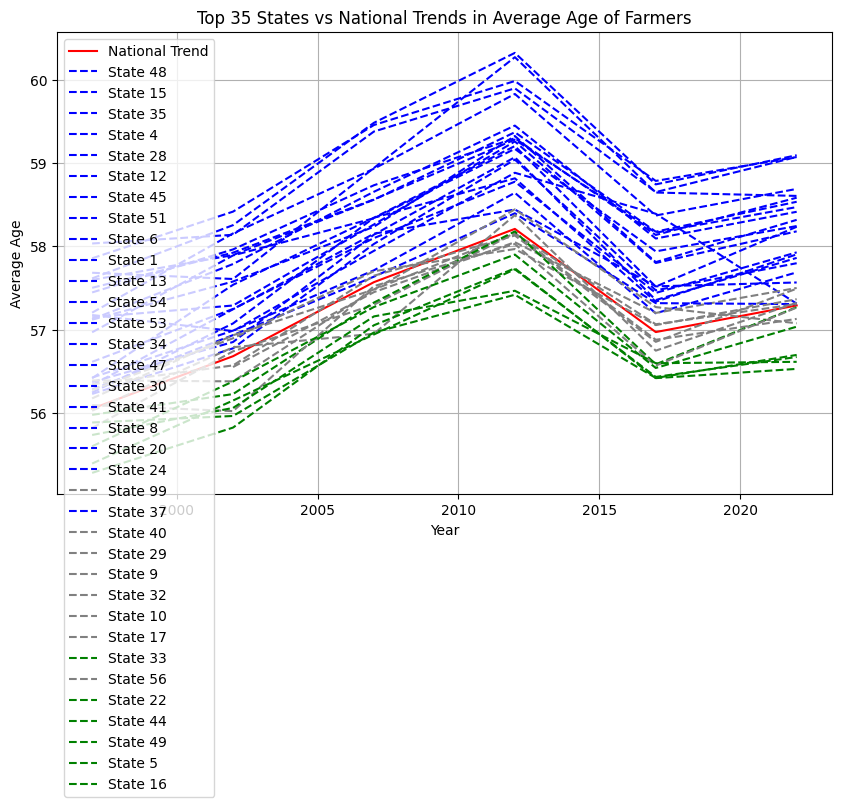

In [ ]:
# Top 35 States vs National Trends in Average Age of Farmers:

# Sort states by their overall combined average age and select the top 25
top_35_states = state_avg_ages_combined.nlargest(35).index

# Merge national trend with state data to calculate whether each state's average is higher or lower
merged_trends = pd.merge(state_average_age_per_year_combined, national_average_age_per_year, on='YEAR', suffixes=('_state', '_national'))

# Define colors: one for states above the national trend, one for states below
above_trend_color = 'blue'
below_trend_color = 'green'

# Plot national trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=national_average_age_per_year,
             x='YEAR',
             y='Combined_Average_Age',
             label='National Trend',
             color='red')

# Plot state trends for the top 35 states
for state_code in top_35_states:
    state_data = merged_trends[merged_trends['STATE_FIPS_CODE'] == state_code]

    # Check if the state's trend is consistently higher or lower than the national trend
    if (state_data['Combined_Average_Age_state'] > state_data['Combined_Average_Age_national']).all():
        state_color = above_trend_color
    elif (state_data['Combined_Average_Age_state'] < state_data['Combined_Average_Age_national']).all():
        state_color = below_trend_color
    else:
        state_color = 'gray'  # Mixed trend

    sns.lineplot(data=state_data,
                 x='YEAR',
                 y='Combined_Average_Age_state',
                 label=f'State {state_code}',
                 linestyle='--',
                 color=state_color)

# Customize the plot
plt.title('Top 35 States vs National Trends in Average Age of Farmers')
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## **Gender Distribution:**

In [ ]:
# Check for any NaN values and handle them (e.g., drop or fill with a valid value)
len(county_data[['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS', 'PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS', 'PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS']])

18765

In [ ]:
# Convert the relevant columns to numeric, coercing any non-numeric values to NaN
county_data['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS'] = pd.to_numeric(county_data['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS'], errors='coerce')
county_data['PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS'] = pd.to_numeric(county_data['PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS'], errors='coerce')
county_data['PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS'] = pd.to_numeric(county_data['PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS'], errors='coerce')

# Replace null values with the median of each column using direct assignment to avoid warnings
county_data['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS'] = county_data['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS'].fillna(county_data['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS'].median())
county_data['PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS'] = county_data['PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS'].fillna(county_data['PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS'].median())
county_data['PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS'] = county_data['PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS'].fillna(county_data['PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS'].median())

# Group by year and sum the gender columns
gender_distribution_per_year = county_data.groupby('YEAR')[['OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS',
                                                            'PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS',
                                                            'PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS']].sum().reset_index()
print(gender_distribution_per_year)

   YEAR  OPERATORS_ALL_FEMALE_NUMBER_OF_OPERATORS  PRODUCERS_ALL_FEMALE_NUMBER_OF_PRODUCERS  PRODUCERS_ALL_MALE_NUMBER_OF_PRODUCERS
0  1997                                  756492.0                                 1003446.0                               1853718.0
1  2002                                 2546581.0                                 1003767.0                               1854311.0
2  2007                                 3029417.0                                 1003767.0                               1854311.0
3  2012                                 2971871.0                                 1004088.0                               1854904.0
4  2017                                  756976.0                                 3751743.0                               6590848.0
5  2022                                  757218.0                                 3800679.0                               6577170.0


# **Regional Variations and Economic Impact:**

### **1. What are the trends in average age for the most productive counties in the U.S., as measured by the dollar value of agricultural production? What about the lowest productive counties in the U.S.?**



In [ ]:
# Correct the pivot table with keyword arguments
age_change_pivot = state_average_age_per_year_sorted.pivot(index='STATE_FIPS_CODE', columns='YEAR', values='AGE_CHANGE_RATE')

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(age_change_pivot, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Age Change Rate (%)'})

# Add title and labels
plt.title('Heatmap of Producers Age Changing Rate by State and Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('State FIPS Code', fontsize=12)

# Display the heatmap
plt.show()


In [ ]:
# Step 1: Calculate the annual rate of change in age for each county
county_data['AGE_CHANGE_RATE'] = county_data.groupby(['STATE_FIPS_CODE', 'COUNTY_CODE'])['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].pct_change() * 100

# Step 2: Calculate the average annual rate of change for each county
county_avg_age_change = county_data.groupby(['STATE_FIPS_CODE', 'COUNTY_CODE'])['AGE_CHANGE_RATE'].mean().reset_index()

# Step 3: Identify counties with accelerating aging (annual change rate above a threshold) and stabilization trends
threshold = 1.0  # For example, a threshold of 2% annual change
county_avg_age_change['Trend'] = county_avg_age_change['AGE_CHANGE_RATE'].apply(
    lambda x: 'Accelerating Aging' if x > threshold else ('Stabilizing' if x < -threshold else 'Neutral')
)

# Step 4: Merge the trend labels back into the original data for reference
county_data_with_trend = pd.merge(county_data, county_avg_age_change[['STATE_FIPS_CODE', 'COUNTY_CODE', 'Trend']],
                                  on=['STATE_FIPS_CODE', 'COUNTY_CODE'], how='left')
print(county_data_with_trend.head())


   STATE_FIPS_CODE  COUNTY_CODE  YEAR AG_LAND_CROPLAND_HARVESTED_ACRES AG_LAND_CROPLAND_HARVESTED_ACRES_ON_OPERATIONS_WITH_TENURE_FULL_OWNER AG_LAND_CROPLAND_HARVESTED_ACRES_ON_OPERATIONS_WITH_TENURE_PART_OWNER AG_LAND_CROPLAND_HARVESTED_ACRES_ON_OPERATIONS_WITH_TENURE_TENANT  AG_LAND_CROPLAND_HARVESTED_NUMBER_OF_OPERATIONS  AG_LAND_CROPLAND_HARVESTED_NUMBER_OF_OPERATIONS_WHERE_TENURE_FULL_OWNER  AG_LAND_CROPLAND_HARVESTED_NUMBER_OF_OPERATIONS_WHERE_TENURE_PART_OWNER  AG_LAND_CROPLAND_HARVESTED_NUMBER_OF_OPERATIONS_WHERE_TENURE_TENANT AG_LAND_OWNED_IN_FARMS_ACRES AG_LAND_OWNED_IN_FARMS_ACRES_ON_OPERATIONS_WITH_TENURE_PART_OWNER  AG_LAND_OWNED_IN_FARMS_NUMBER_OF_OPERATIONS AG_LAND_RENTED_FROM_OTHERS_IN_FARMS_ACRES AG_LAND_RENTED_FROM_OTHERS_IN_FARMS_ACRES_ON_OPERATIONS_WITH_TENURE_PART_OWNER  AG_LAND_RENTED_FROM_OTHERS_IN_FARMS_NUMBER_OF_OPERATIONS FARM_OPERATIONS_ACRES_OPERATED FARM_OPERATIONS_ACRES_OPERATED_ON_OPERATIONS_WITH_TENURE_FULL_OWNER  \
0                1            1  1997 

<ipython-input-41-cdce1fbd26b2>:2: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [ ]:
# Step 1: Total number of counties
total_counties = county_data_with_trend['COUNTY_CODE'].nunique()

# Step 2: Number of counties labeled as 'Accelerating Aging'
accelerating_aging_counties = county_data_with_trend[county_data_with_trend['Trend'] == 'Accelerating Aging']['COUNTY_CODE'].nunique()

# Step 3: Calculate the percentage
percentage_accelerating_aging = (accelerating_aging_counties / total_counties) * 100

# Print the result
print(f"Percentage of counties labeled as 'Accelerating Aging': {percentage_accelerating_aging:.2f}%")


Percentage of counties labeled as 'Accelerating Aging': 60.44%


In [ ]:
median_values = {
    'FARM SALES: (LESS THAN 1,000 $)': 500,
    'FARM SALES: (1,000 TO 2,499 $)': 1750,
    'FARM SALES: (2,500 TO 4,999 $)': 3750,
    'FARM SALES: (5,000 TO 9,999 $)': 7500,
    'FARM SALES: (10,000 TO 24,999 $)': 17500,
    'FARM SALES: (25,000 TO 49,999 $)': 37500,
    'FARM SALES: (50,000 TO 99,999 $)': 75000,
    'FARM SALES: (100,000 TO 249,999 $)': 175000,
    'FARM SALES: (250,000 TO 499,999 $)': 375000,
    'FARM SALES: (500,000 TO 999,999 $)': 750000,
    'FARM SALES: (1,000,000 OR MORE $)': 1500000
}


In [ ]:
# Convert invalid values (e.g., '-') to NaN, then fill them with 0
state_level_data['FARM SALES: (LESS THAN 1,000 $)'] = pd.to_numeric(state_level_data['FARM SALES: (LESS THAN 1,000 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (1,000 TO 2,499 $)'] = pd.to_numeric(state_level_data['FARM SALES: (1,000 TO 2,499 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (2,500 TO 4,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (2,500 TO 4,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (5,000 TO 9,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (5,000 TO 9,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (10,000 TO 24,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (10,000 TO 24,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (25,000 TO 49,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (25,000 TO 49,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (50,000 TO 99,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (50,000 TO 99,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (100,000 TO 249,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (100,000 TO 249,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (250,000 TO 499,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (250,000 TO 499,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (500,000 TO 999,999 $)'] = pd.to_numeric(state_level_data['FARM SALES: (500,000 TO 999,999 $)'], errors='coerce').fillna(0)
state_level_data['FARM SALES: (1,000,000 OR MORE $)'] = pd.to_numeric(state_level_data['FARM SALES: (1,000,000 OR MORE $)'], errors='coerce').fillna(0)

# Recalculate total farm production value
state_level_data['Total_Farm_Production_Value'] = (
    state_level_data['FARM SALES: (LESS THAN 1,000 $)'] * median_values['FARM SALES: (LESS THAN 1,000 $)'] +
    state_level_data['FARM SALES: (1,000 TO 2,499 $)'] * median_values['FARM SALES: (1,000 TO 2,499 $)'] +
    state_level_data['FARM SALES: (2,500 TO 4,999 $)'] * median_values['FARM SALES: (2,500 TO 4,999 $)'] +
    state_level_data['FARM SALES: (5,000 TO 9,999 $)'] * median_values['FARM SALES: (5,000 TO 9,999 $)'] +
    state_level_data['FARM SALES: (10,000 TO 24,999 $)'] * median_values['FARM SALES: (10,000 TO 24,999 $)'] +
    state_level_data['FARM SALES: (25,000 TO 49,999 $)'] * median_values['FARM SALES: (25,000 TO 49,999 $)'] +
    state_level_data['FARM SALES: (50,000 TO 99,999 $)'] * median_values['FARM SALES: (50,000 TO 99,999 $)'] +
    state_level_data['FARM SALES: (100,000 TO 249,999 $)'] * median_values['FARM SALES: (100,000 TO 249,999 $)'] +
    state_level_data['FARM SALES: (250,000 TO 499,999 $)'] * median_values['FARM SALES: (250,000 TO 499,999 $)'] +
    state_level_data['FARM SALES: (500,000 TO 999,999 $)'] * median_values['FARM SALES: (500,000 TO 999,999 $)'] +
    state_level_data['FARM SALES: (1,000,000 OR MORE $)'] * median_values['FARM SALES: (1,000,000 OR MORE $)']
)

# Check the results of the calculation
print(state_level_data[['Year', 'GEO', 'Total_Farm_Production_Value']].head())


   Year      GEO  Total_Farm_Production_Value
0  2002  Alabama                   17511750.0
1  2002  Alabama                  178978500.0
2  2002  Alabama                  608668250.0
3  2002  Alabama                  466644000.0
4  2002  Alabama                  483348750.0


In [ ]:
# Assuming state_level_data contains 'Data Item' and sales columns
# Extract age group
def extract_age_group(data_item):
    match = re.search(r'AGE (.*)', data_item)
    return match.group(1) if match else 'Other'

# Create a new column 'Age_Group' that indicates the age group for each entry
state_level_data['Age_Group'] = state_level_data['Data Item'].apply(extract_age_group)

# Summarize sales for each age group
# Assuming the sales columns have names like 'FARM SALES: (LESS THAN 1,000 $)'
sales_columns = [
    'FARM SALES: (LESS THAN 1,000 $)', 'FARM SALES: (1,000 TO 2,499 $)',
    'FARM SALES: (2,500 TO 4,999 $)', 'FARM SALES: (5,000 TO 9,999 $)',
    'FARM SALES: (10,000 TO 24,999 $)', 'FARM SALES: (25,000 TO 49,999 $)',
    'FARM SALES: (50,000 TO 99,999 $)', 'FARM SALES: (100,000 TO 249,999 $)',
    'FARM SALES: (250,000 TO 499,999 $)', 'FARM SALES: (500,000 TO 999,999 $)',
    'FARM SALES: (1,000,000 OR MORE $)'
]

# Calculate the total sales for each age group
state_level_data['Total_Farm_Sales'] = state_level_data[sales_columns].sum(axis=1)

# Group by age group and sum the total sales for each group
age_group_sales = state_level_data.groupby('Age_Group')['Total_Farm_Sales'].sum().reset_index()

# Display the summarized total farm sales for each age group
print(age_group_sales)

# Based on this data, you can build models, such as using linear regression,
# to explore the relationship between age group and total sales.



                         Age_Group  Total_Farm_Sales
0   25 TO 34 - NUMBER OF OPERATORS          643902.0
1   25 TO 34 - NUMBER OF PRODUCERS          947952.0
2   35 TO 44 - NUMBER OF OPERATORS         1698460.0
3   35 TO 44 - NUMBER OF PRODUCERS         1633922.0
4   45 TO 49 - NUMBER OF OPERATORS         1440372.0
5   45 TO 54 - NUMBER OF PRODUCERS         2268168.0
6   50 TO 54 - NUMBER OF OPERATORS         1767830.0
7   55 TO 59 - NUMBER OF OPERATORS         1774600.0
8   55 TO 64 - NUMBER OF PRODUCERS         3585758.0
9   60 TO 64 - NUMBER OF OPERATORS         1652362.0
10  65 TO 69 - NUMBER OF OPERATORS         1369208.0
11  65 TO 74 - NUMBER OF PRODUCERS         3169734.0
12     GE 70 - NUMBER OF OPERATORS         2460312.0
13     GE 75 - NUMBER OF PRODUCERS         1726336.0
14     LT 25 - NUMBER OF OPERATORS           79108.0
15     LT 25 - NUMBER OF PRODUCERS          215886.0
16                           Other          158369.5


In [ ]:
import re


def extract_age_group(data_item):
    match = re.search(r'AGE (.*)', data_item)
    return match.group(1) if match else 'Other'

state_level_data['Age_Group'] = state_level_data['Data Item'].apply(extract_age_group)

In [ ]:
def extract_age_group(data_item):
    match = re.search(r'AGE (.*)', data_item)
    return match.group(1) if match else 'Other'


state_level_data['Age_Group'] = state_level_data['Data Item'].apply(extract_age_group)


In [ ]:
import pandas as pd
import re


def extract_age_group(data_item):
    match = re.search(r'AGE (.*)', data_item)
    return match.group(1) if match else 'Other'

state_level_data['Age_Group'] = state_level_data['Data Item'].apply(extract_age_group)


sales_columns = [
    'FARM SALES: (LESS THAN 1,000 $)', 'FARM SALES: (1,000 TO 2,499 $)',
    'FARM SALES: (2,500 TO 4,999 $)', 'FARM SALES: (5,000 TO 9,999 $)',
    'FARM SALES: (10,000 TO 24,999 $)', 'FARM SALES: (25,000 TO 49,999 $)',
    'FARM SALES: (50,000 TO 99,999 $)', 'FARM SALES: (100,000 TO 249,999 $)',
    'FARM SALES: (250,000 TO 499,999 $)', 'FARM SALES: (500,000 TO 999,999 $)',
    'FARM SALES: (1,000,000 OR MORE $)'
]


state_level_data['Total_Farm_Sales'] = state_level_data[sales_columns].sum(axis=1)

age_group_sales = state_level_data.groupby('Age_Group')['Total_Farm_Sales'].sum().reset_index()


print(age_group_sales)




                         Age_Group  Total_Farm_Sales
0   25 TO 34 - NUMBER OF OPERATORS          643902.0
1   25 TO 34 - NUMBER OF PRODUCERS          947952.0
2   35 TO 44 - NUMBER OF OPERATORS         1698460.0
3   35 TO 44 - NUMBER OF PRODUCERS         1633922.0
4   45 TO 49 - NUMBER OF OPERATORS         1440372.0
5   45 TO 54 - NUMBER OF PRODUCERS         2268168.0
6   50 TO 54 - NUMBER OF OPERATORS         1767830.0
7   55 TO 59 - NUMBER OF OPERATORS         1774600.0
8   55 TO 64 - NUMBER OF PRODUCERS         3585758.0
9   60 TO 64 - NUMBER OF OPERATORS         1652362.0
10  65 TO 69 - NUMBER OF OPERATORS         1369208.0
11  65 TO 74 - NUMBER OF PRODUCERS         3169734.0
12     GE 70 - NUMBER OF OPERATORS         2460312.0
13     GE 75 - NUMBER OF PRODUCERS         1726336.0
14     LT 25 - NUMBER OF OPERATORS           79108.0
15     LT 25 - NUMBER OF PRODUCERS          215886.0
16                           Other          158369.5


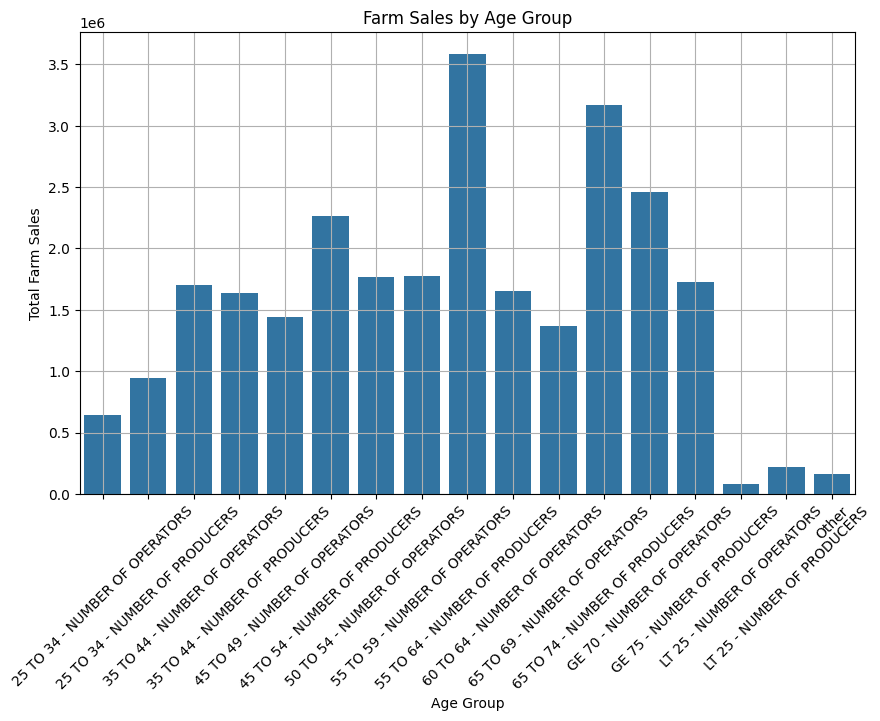

In [ ]:
# Age Group And Farm Sale
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Age_Group', y='Total_Farm_Sales', data=age_group_sales)
plt.title('Farm Sales by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Farm Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:

age_group_sales_cleaned = age_group_sales.dropna(subset=['Age_Group', 'Total_Farm_Sales'])




Pearson Correlation Coefficient: 0.67, P-value: 0.00935
Linear Regression Results: Slope = 38337.27, Intercept = -200530.06, R-squared = 0.44


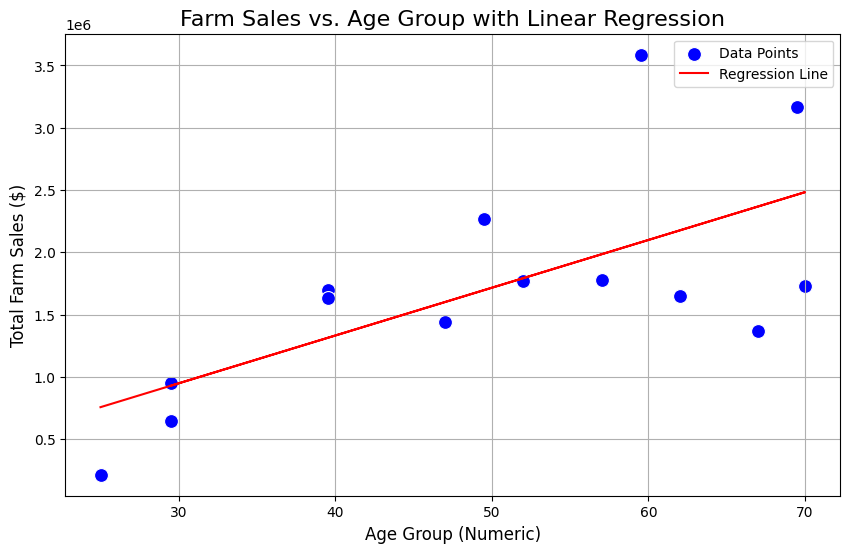

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Improved function to extract age ranges and convert them to a numeric midpoint
def extract_age_from_group(age_group):
    if 'TO' in age_group:
        # Match age ranges in the format "X TO Y"
        match = re.search(r'(\d+) TO (\d+)', age_group)
        if match:
            return (int(match.group(1)) + int(match.group(2))) / 2
    elif 'GE' in age_group:
        # Handle "GE" (greater than or equal to) age ranges
        return 70
    elif 'LT' in age_group:
        # Handle "LT" (less than) age ranges
        return 25
    else:
        return np.nan  # Handle cases that cannot be parsed

# Apply the conversion function to extract numeric age values
age_groups_numeric = age_group_sales_cleaned['Age_Group'].apply(extract_age_from_group)

# Remove rows that couldn't be parsed (i.e., NaN values)
age_group_sales_cleaned = age_group_sales_cleaned[age_groups_numeric.notna()]
age_groups_numeric = age_groups_numeric.dropna()

# Get the corresponding values for regression and correlation
X = age_groups_numeric.values  # Age group as the feature (1D array for pearsonr)
y = age_group_sales_cleaned['Total_Farm_Sales'].values  # Total sales as the target variable

# Calculate the Pearson correlation coefficient (X and y should both be 1D arrays)
pearson_corr, p_value = pearsonr(X, y)

print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}, P-value: {p_value:.5f}")

# Build the linear regression model (reshape X to 2D for the regression)
X_reshaped = X.reshape(-1, 1)  # Reshape for regression model
model = LinearRegression()
model.fit(X_reshaped, y)

# Output regression results
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X_reshaped, y)

print(f"Linear Regression Results: Slope = {slope:.2f}, Intercept = {intercept:.2f}, R-squared = {r_squared:.2f}")

# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_groups_numeric, y=age_group_sales_cleaned['Total_Farm_Sales'], s=100, color='blue', label='Data Points')
plt.plot(age_groups_numeric, model.predict(X_reshaped), color='red', label='Regression Line')
plt.title('Farm Sales vs. Age Group with Linear Regression', fontsize=16)
plt.xlabel('Age Group (Numeric)', fontsize=12)
plt.ylabel('Total Farm Sales ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()




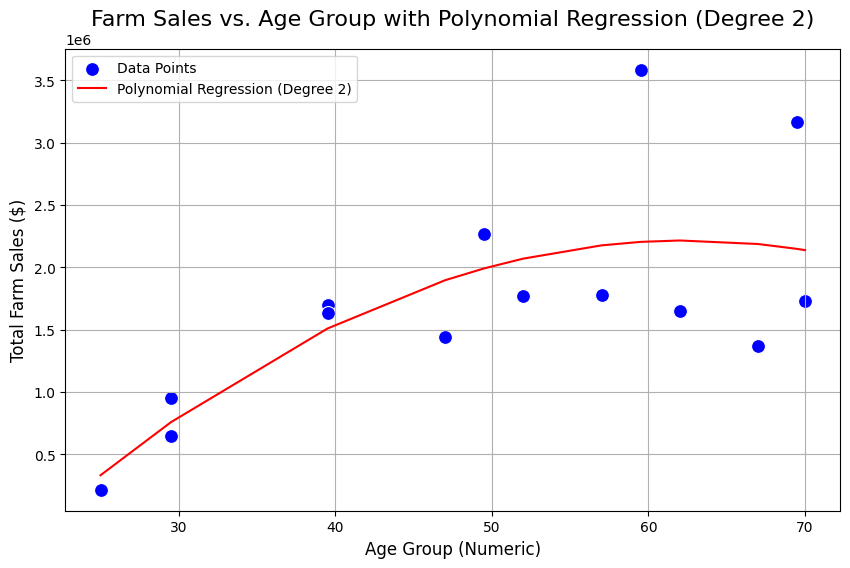

Polynomial Regression R-squared (Degree 2): 0.53


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)

#  poly-regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_groups_numeric, y=age_group_sales_cleaned['Total_Farm_Sales'])
plt.plot(age_groups_numeric, poly_model.predict(X), color='green')
plt.title('Farm Sales vs. Age Group with Polynomial Regression')
plt.xlabel('Age Group (Numeric)')
plt.ylabel('Total Farm Sales')
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Define age group categories (Youth, Middle-Aged, Older)
def categorize_age_group(age):
    if age < 35:
        return 'Youth (25-34)'
    elif 35 <= age < 55:
        return 'Middle-Aged (35-54)'
    else:
        return 'Older (55+)'

# Convert age groups into numerical categories
age_group_sales_cleaned['Age_Group_Category'] = age_groups_numeric.apply(categorize_age_group)

# Step 2: Calculate the average total farm sales for each age group
age_group_avg_sales = age_group_sales_cleaned.groupby('Age_Group_Category')['Total_Farm_Sales'].mean().reset_index()

# Step 3: Visualize the average farm sales for different age groups
plt.figure(figsize=(10, 6))
sns.barplot(x='Age_Group_Category', y='Total_Farm_Sales', data=age_group_avg_sales)
plt.title('Average Farm Sales by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Total Farm Sales')
plt.grid(True)
plt.show()

# Step 4: Check for significant differences between age groups (ANOVA)
# Perform ANOVA on the farm sales across different age groups
youth_sales = age_group_sales_cleaned[age_group_sales_cleaned['Age_Group_Category'] == 'Youth (25-34)']['Total_Farm_Sales']
middle_aged_sales = age_group_sales_cleaned[age_group_sales_cleaned['Age_Group_Category'] == 'Middle-Aged (35-54)']['Total_Farm_Sales']
older_sales = age_group_sales_cleaned[age_group_sales_cleaned['Age_Group_Category'] == 'Older (55+)']['Total_Farm_Sales']

# Perform one-way ANOVA
anova_result = stats.f_oneway(youth_sales, middle_aged_sales, older_sales)
print(f"ANOVA Results: F-statistic = {anova_result.statistic}, P-value = {anova_result.pvalue}")



In [ ]:
# Classify regions into high production and low production based on total farm production value
top_10_percent_threshold = state_level_data['Total_Farm_Production_Value'].quantile(0.9)
high_production_states = state_level_data[state_level_data['Total_Farm_Production_Value'] >= top_10_percent_threshold]

low_10_percent_threshold = state_level_data['Total_Farm_Production_Value'].quantile(0.1)
low_production_states = state_level_data[state_level_data['Total_Farm_Production_Value'] <= low_10_percent_threshold]

# Check high production and low production regions
print("High Production States:", high_production_states[['Year', 'GEO', 'Total_Farm_Production_Value']].head())
print("Low Production States:", low_production_states[['Year', 'GEO', 'Total_Farm_Production_Value']].head())

In [ ]:
#Classfication of high production states and low production states
print(high_production_states[['Year', 'GEO', 'OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS']].isnull().sum())
print(high_production_states[['Year', 'GEO', 'OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS']].dropna().head())


In [ ]:
# Step 1: Classify regions into high production and low production based on total farm production value
top_10_percent_threshold = state_level_data['Total_Farm_Production_Value'].quantile(0.9)
low_10_percent_threshold = state_level_data['Total_Farm_Production_Value'].quantile(0.1)

# High production regions (top 10%)
high_production_states = state_level_data[state_level_data['Total_Farm_Production_Value'] >= top_10_percent_threshold]

# Low production regions (bottom 10%)
low_production_states = state_level_data[state_level_data['Total_Farm_Production_Value'] <= low_10_percent_threshold]

# Step 2: Calculate the average farmer age trend
# Replace 'OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS' with the correct column name for farmer age
high_production_age_trend = high_production_states.groupby('Year')['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].mean().reset_index()
low_production_age_trend = low_production_states.groupby('Year')['OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS'].mean().reset_index()

# Step 3: Plot the trend in average farmer age
plt.figure(figsize=(10, 6))

# Plot the trend for high production states
sns.lineplot(x='Year', y='OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', data=high_production_age_trend, label='High Production States', marker='o')

# Plot the trend for low production states
sns.lineplot(x='Year', y='OPERATORS_PRINCIPAL_AGE_AVG_MEASURED_IN_YEARS', data=low_production_age_trend, label='Low Production States', marker='o')

# Add title and labels
plt.title('Trends in Principal Operator Age: High vs. Low Production States')
plt.xlabel('Year')
plt.ylabel('Average Principal Operator Age (Measured in Years)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# **Inflation Adjustment and Sales Analysis:**

### **1. When analyzing farm production and economic impact, how does the use of an inflation adjustment measure for the value of agricultural products affect the analysis?**
### **2. Does adjusting for inflation reveal different trends in the relationship between farmer age and farm production?**

In [ ]:
# @title Default title text
# Load GDP price index data

path_inflation = '/content/drive/My Drive/HDSI/Prompt2/inflation_GDP_price_index.xlsx'
#sales_data = pd.read_csv('/content/drive/My Drive/HDSI/Prompt2/prompt2_prompt3_sales.csv', low_memory=False)

df_inflation = pd.read_excel(path_inflation)

# Clean the inflation data: drop unnecessary rows and reset the index
df_inflation = df_inflation.drop([0, 1, 2, 3, 5]).reset_index(drop=True)

# Rename the columns using the first row of the cleaned data
df_inflation.columns = df_inflation.iloc[0]
df_inflation = df_inflation.drop(0).reset_index(drop=True)

# Set the year (second column) as the index
df_inflation.index = df_inflation.iloc[:, 1]

# Drop the first two columns, as they are unnecessary for the analysis
df_inflation = df_inflation.drop(df_inflation.columns[:2], axis=1)

# Extract the GDP price index row corresponding to 2017 as the base year
gdp_index = df_inflation.iloc[0]  # Assuming the first row corresponds to 2017

# Print the extracted GDP index
print("GDP Price Index (2017 base year):")
print(gdp_index)

GDP Price Index (2017 base year):
0
1990     59.307
1991     61.303
1992     62.701
1993     64.189
1994     65.557
1995     66.933
1996     68.156
1997     69.337
1998     70.102
1999     71.084
2000     72.709
2001     74.385
2002       75.5
2003     77.012
2004     79.069
2005     81.537
2006     84.074
2007     86.352
2008     87.977
2009     88.557
2010     89.618
2011     91.466
2012     93.176
2013     94.786
2014     96.436
2015     97.277
2016     98.208
2017        100
2018     102.29
2019    104.008
2020    105.407
2021     110.22
2022    117.996
Name:         Gross domestic product, dtype: object


In [ ]:
path_sales = '/content/drive/My Drive/HDSI/Prompt2/prompt2_prompt3_sales.csv'

# Load the sales data
df_sales = pd.read_csv(path_sales)

# Select the necessary identification columns (assuming first three columns include state and county codes)
id_columns = df_sales.iloc[:, :3]

# Filter columns related to dollar sales
dollar_columns = df_sales.filter(like='DOLLARS')

# Combine the identification columns with the dollar sales columns
df_sales_t = pd.concat([id_columns, dollar_columns], axis=1)

# Create a combined FIPS code for counties
df_sales_t['FIPS'] = df_sales_t['STATE_FIPS_CODE'].astype(str).str.zfill(2) + df_sales_t['COUNTY_CODE'].astype(str).str.zfill(3)

# Sum up the sales values across all dollar columns to get total production for each county
df_sales_t['TOTAL_SALES'] = df_sales_t[dollar_columns.columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)

# Sort the counties by total sales to find the most and least productive counties
most_productive_counties = df_sales_t.nlargest(10, 'TOTAL_SALES')
least_productive_counties = df_sales_t.nsmallest(10, 'TOTAL_SALES')

# Print the most and least productive counties
print("Most Productive Counties:\n", most_productive_counties[['FIPS', 'TOTAL_SALES']])
print("\nLeast Productive Counties:\n", least_productive_counties[['FIPS', 'TOTAL_SALES']])


<ipython-input-61-8390548397bd>:4: DtypeWarning:

Columns (3,7,30,32,36,37,40,48,49,50,54,55,56,61,71,72,81,82,83,86,91,112,138,140,144,145,146,160,162,163,166,188,189,192,194,208,210,211,214,216,217,218,240,241,244,245,246,249,251,252,253,257,258,259,263,264,265,269,279,291,292,295,296,297,306,307,310,311,312,313,316,317,318,319,329,330,331,349,351,352,353,357,359,361,366,374,375,378,379,380,387,388,389,393,394,397,433,434,437,439,440,443,445,446,447,455,457,458,459,469,471,473,474,476,478,479,481,483,484,486,488,489,491,493,494,496,498,499,501,503,504,508,510,512,513,515,517,518,520,522,523,525,527,528,530,532,537,543,549,555,557,558,561,562,563,564,568,569,573,574,578,579,589,615,616,619,620,622,626,628,630,632,634,635,638,641,642,646,647,648,649,652,657,658,661,662,663,666,668,669,672,673,674,675,679,680,681,685,687,689,690,692,693,695,697,698,700,702,703,705,707,708,710,712,713,715,717,718,719,720,724,725,728,745,746,747,751,752,753,757,758,759,763,764,765,769,770,771,775,776,777,

Most Productive Counties:
         FIPS   TOTAL_SALES
18745  99999  3.015800e+10
18742  99999  2.247238e+10
18744  99999  2.239310e+10
18743  99999  2.035018e+10
1349   06999  5.656246e+09
2217   12999  4.949484e+09
1346   06999  4.845530e+09
1348   06999  4.359267e+09
1347   06999  3.785720e+09
2216   12999  3.066167e+09

Least Productive Counties:
      FIPS  TOTAL_SALES
0   01001          0.0
1   01001          0.0
2   01001          0.0
4   01001          0.0
6   01003          0.0
7   01003          0.0
12  01005          0.0
13  01005          0.0
16  01005          0.0
18  01007          0.0


In [ ]:
df_sales_t_county = df_sales_t[(df_sales_t['COUNTY_CODE'] != 99) & (df_sales_t['COUNTY_CODE'] != 999)]
df_sales_t_state = df_sales_t[(df_sales_t['COUNTY_CODE'] == 99)]
df_sales_t_us = df_sales_t[(df_sales_t['COUNTY_CODE'] == 999)]
non_na_counts_county = df_sales_t_county.count()
non_na_counts_state = df_sales_t_state.count()
non_na_counts_us = df_sales_t_us.count()
print(non_na_counts_county)

STATE_FIPS_CODE                                                                                   18261
COUNTY_CODE                                                                                       18261
YEAR                                                                                              18261
AQUATIC_PLANTS_SALES_MEASURED_IN_DOLLARS                                                           1190
BEDDING_PLANT_TOTALS_SALES_MEASURED_IN_DOLLARS                                                     8635
BULBS_CORMS_RHIZOMES_TUBERS_DRY_SALES_MEASURED_IN_DOLLARS                                          1870
CUT_FLOWERS_CUT_CULTIVATED_GREENS_SALES_MEASURED_IN_DOLLARS                                        4461
FLORICULTURE_OTHER_SALES_MEASURED_IN_DOLLARS                                                       1958
FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS                                                      9285
FLOWER_SEEDS_SALES_MEASURED_IN_DOLLARS                          

In [ ]:
!pip install pandas matplotlib plotly kaleido
!pip install plotly pandas numpy

In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

pio.renderers.default = 'colab'

# Convert the column to numeric, coercing non-numeric values to NaN
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)

# Filter the DataFrame by specific years
df_sales_t_county_filtered = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])].copy()

# Fill NaN values in 'FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS' with 0
df_sales_t_county_filtered['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].fillna(0, inplace=False)

# Calculate the minimum and maximum sales values for the color range
min_sales = df_sales_t_county_filtered['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].min()
max_sales = df_sales_t_county_filtered['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].max()

# Create a choropleth map of sales data across counties
fig = px.choropleth(
    df_sales_t_county_filtered,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS',  # Column for sales values
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_sales, max_sales],  # Set the same color scale range for all years
    labels={'FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS': 'Total Sales (in Dollars)'},
    title='Floriculture Sales in US (2007, 2012, 2017, 2022)'
)

# Make the figure larger
fig.update_layout(
    width=1400,  # Set figure width
    height=700,  # Set figure height
)

# Fit the map to show the counties with data
fig.update_geos(fitbounds="locations", visible=False)

# Show the figure
fig.show()


<ipython-input-64-cd8eacfd5633>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

pio.renderers.default = 'colab'
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)
df_sales_t_county = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])]
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].fillna(0, inplace=True)
df_sales_ca = df_sales_t_county[df_sales_t_county['FIPS'].str.startswith('06')]

min_sales = df_sales_ca['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].min()
max_sales = df_sales_ca['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].max()

fig = px.choropleth(
    df_sales_ca,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS',  # Column for sales values
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_sales, max_sales],  # Set the same color scale range for all years
    labels={'FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS': 'Total Sales (in Dollars)'},
    title='Floriculture Sales in California (2007, 2012, 2017, 2022)'
)

fig.update_layout(
    width=1000,  # Set figure width
    height=700,  # Set figure height
)

fig.update_geos(
    visible=False,
    resolution=50,
    projection_scale=5,  # Zoom in scale
    center={"lat": 37.5, "lon": -119},  # Center around California
    lonaxis_range=[-125, -114],  # Longitude range for California
    lataxis_range=[32, 42],  # Latitude range for California
)

fig.show()


<ipython-input-65-acac809fcc17>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-65-acac809fcc17>:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-65-acac809fcc17>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

pio.renderers.default = 'colab'
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)
df_sales_t_county = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])]
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].fillna(0, inplace=True)
df_sales_fl = df_sales_t_county[df_sales_t_county['FIPS'].str.startswith('12')]

min_sales = df_sales_fl['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].min()
max_sales = df_sales_fl['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].max()

fig = px.choropleth(
    df_sales_fl,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS',  # Column for sales values
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_sales, max_sales],  # Set the same color scale range for all years
    labels={'FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS': 'Total Sales (in Dollars)'},
    title='Floriculture Sales in Florida (2007, 2012, 2017, 2022)'
)

fig.update_layout(
    width=1000,  # Set figure width
    height=700,  # Set figure height
)

fig.update_geos(
    visible=False,
    resolution=50,
    projection_scale=5,  # Zoom in scale
    center={"lat": 27.8, "lon": -83.0},  # Center around Florida
    lonaxis_range=[-88, -79],  # Longitude range for Florida
    lataxis_range=[24, 31],  # Latitude range for Florida
)


fig.show()

<ipython-input-66-418625929c02>:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

# Set renderer to iframe for displaying in a notebook or HTML
pio.renderers.default = 'colab'

# Define GDP price index for each year
gdp_price_index = {
    2007: 86.352,
    2012: 93.176,
    2017: 100,
    2022: 117.996
}

# Convert the sales column to numeric, handling errors
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)

# Filter data to only include the years 2007, 2012, 2017, and 2022
df_sales_filtered = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])]

# Calculate inflation-adjusted sales
df_sales_filtered['GDP_PRICE_INDEX'] = df_sales_filtered['YEAR'].map(gdp_price_index)
df_sales_filtered['INFLATION_ADJUSTED_SALES'] = (
    df_sales_filtered['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] /
    df_sales_filtered['GDP_PRICE_INDEX'] * 100
)

# Filter data to only include FIPS codes that start with "12" (Florida)
df_sales_florida = df_sales_filtered[df_sales_filtered['FIPS'].str.startswith('12')]

# Find the range for the inflation-adjusted color scale (min and max inflation-adjusted sales values)
min_sales_adj = df_sales_florida['INFLATION_ADJUSTED_SALES'].min()
max_sales_adj = df_sales_florida['INFLATION_ADJUSTED_SALES'].max()

# Plot using Plotly Express, adding animation for the 'YEAR' column
fig = px.choropleth(
    df_sales_florida,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='INFLATION_ADJUSTED_SALES',  # Column for inflation-adjusted sales
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_sales_adj, max_sales_adj],  # Set the same color scale range for all years
    labels={'INFLATION_ADJUSTED_SALES': 'Inflation-Adjusted Sales (in Dollars)'},
    title='Inflation-Adjusted Floriculture Sales in Florida (based on 2017)'
)

# Customize the layout of the figure
fig.update_layout(
    width=1000,  # Set figure width
    height=700,  # Set figure height
)

# Adjust the map to zoom in on Florida by setting the geo boundaries
fig.update_geos(
    visible=False,
    resolution=50,
    projection_scale=5,  # Zoom in scale
    center={"lat": 27.8, "lon": -83.0},  # Center around Florida
    lonaxis_range=[-88, -79],  # Longitude range for Florida
    lataxis_range=[24, 31],  # Latitude range for Florida
)

# Show the figure with animation
fig.show()


In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

# Set renderer to iframe for displaying in a notebook or HTML
pio.renderers.default = 'colab'

# Define GDP price index for each year
gdp_price_index = {
    2007: 86.352,
    2012: 93.176,
    2017: 100,
    2022: 117.996
}

# Convert the sales column to numeric, handling errors
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)

# Filter data to only include the years 2007, 2012, 2017, and 2022
df_sales_filtered = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])]

# Calculate inflation-adjusted sales
df_sales_filtered['GDP_PRICE_INDEX'] = df_sales_filtered['YEAR'].map(gdp_price_index)
df_sales_filtered['INFLATION_ADJUSTED_SALES'] = (
    df_sales_filtered['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] /
    df_sales_filtered['GDP_PRICE_INDEX'] * 100
)

# Filter data to only include FIPS codes that start with "12" (Florida)
df_sales_florida = df_sales_filtered[df_sales_filtered['FIPS'].str.startswith('12')]

# Calculate total sales for Florida per year
florida_total_sales_per_year = df_sales_florida.groupby('YEAR')['INFLATION_ADJUSTED_SALES'].sum().reset_index()
florida_total_sales_per_year.rename(columns={'INFLATION_ADJUSTED_SALES': 'TOTAL_FLORIDA_SALES'}, inplace=True)

# Merge total sales with the original Florida dataframe
df_sales_florida = df_sales_florida.merge(florida_total_sales_per_year, on='YEAR')

# Calculate the percentage of each county's sales relative to the total sales for Florida in that year
df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL'] = (
    df_sales_florida['INFLATION_ADJUSTED_SALES'] / df_sales_florida['TOTAL_FLORIDA_SALES'] * 100
)

# Find the range for the percentage color scale (min and max percentages)
min_percentage = df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL'].min()
max_percentage = df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL'].max()

# Plot using Plotly Express, adding animation for the 'YEAR' column
fig = px.choropleth(
    df_sales_florida,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='PERCENTAGE_OF_FLORIDA_TOTAL',  # Column for the percentage of total Florida sales
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_percentage, max_percentage],  # Set the same color scale range for all years
    labels={'PERCENTAGE_OF_FLORIDA_TOTAL': 'Percentage of Florida Total (%)'},
    title='County Percentage of Total Floriculture Inflation adjusted Sales in Florida (2007, 2012, 2017, 2022)'
)

# Customize the layout of the figure
fig.update_layout(
    width=1000,  # Set figure width
    height=700,  # Set figure height
)

# Adjust the map to zoom in on Florida by setting the geo boundaries
fig.update_geos(
    visible=False,
    resolution=50,
    projection_scale=5,  # Zoom in scale
    center={"lat": 27.8, "lon": -83.0},  # Center around Florida
    lonaxis_range=[-88, -79],  # Longitude range for Florida
    lataxis_range=[24, 31],  # Latitude range for Florida
)

# Show the figure with animation
fig.show()


In [ ]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

# Set renderer to iframe for displaying in a notebook or HTML
pio.renderers.default = 'colab'

# Convert the sales column to numeric, handling errors
df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] = pd.to_numeric(
    df_sales_t_county['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'], errors='coerce'
)

# Filter data to only include the years 2007, 2012, 2017, and 2022
df_sales_filtered = df_sales_t_county[df_sales_t_county['YEAR'].isin([2007, 2012, 2017, 2022])]

# Filter data to only include FIPS codes that start with "12" (Florida)
df_sales_florida = df_sales_filtered[df_sales_filtered['FIPS'].str.startswith('12')]

# 1. Calculate total non-inflation adjusted sales for Florida per year
florida_total_sales_per_year_raw = df_sales_florida.groupby('YEAR')['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'].sum().reset_index()
florida_total_sales_per_year_raw.rename(columns={'FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS': 'TOTAL_FLORIDA_SALES_RAW'}, inplace=True)

# 2. Merge total non-inflation adjusted sales with the original Florida dataframe
df_sales_florida = df_sales_florida.merge(florida_total_sales_per_year_raw, on='YEAR')

# 3. Calculate the percentage of each county's sales relative to the total non-inflation adjusted sales for Florida in that year
df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL_RAW'] = (
    df_sales_florida['FLORICULTURE_TOTALS_SALES_MEASURED_IN_DOLLARS'] / df_sales_florida['TOTAL_FLORIDA_SALES_RAW'] * 100
)

# 4. Find the range for the non-inflation-adjusted percentage color scale (min and max percentages)
min_percentage_raw = df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL_RAW'].min()
max_percentage_raw = df_sales_florida['PERCENTAGE_OF_FLORIDA_TOTAL_RAW'].max()

# Plot using Plotly Express, adding animation for the 'YEAR' column, using non-inflation adjusted sales percentages
fig = px.choropleth(
    df_sales_florida,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",  # GeoJSON file for US counties
    locations='FIPS',  # Column with FIPS codes
    color='PERCENTAGE_OF_FLORIDA_TOTAL_RAW',  # Column for the non-inflation-adjusted percentage
    color_continuous_scale='YlGnBu',  # Color scale
    animation_frame='YEAR',  # Animate by the 'YEAR' column (2007, 2012, 2017, 2022)
    range_color=[min_percentage_raw, max_percentage_raw],  # Set the same color scale range for all years
    labels={'PERCENTAGE_OF_FLORIDA_TOTAL_RAW': 'Non-Inflation Adjusted Percentage of Florida Total (%)'},
    title='Non-Inflation Adjusted County Percentage of Total Floriculture Sales in Florida (2007, 2012, 2017, 2022)'
)

# Customize the layout of the figure
fig.update_layout(
    width=1000,  # Set figure width
    height=700,  # Set figure height
)

# Adjust the map to zoom in on Florida by setting the geo boundaries
fig.update_geos(
    visible=False,
    resolution=50,
    projection_scale=5,  # Zoom in scale
    center={"lat": 27.8, "lon": -83.0},  # Center around Florida
    lonaxis_range=[-88, -79],  # Longitude range for Florida
    lataxis_range=[24, 31],  # Latitude range for Florida
)

# Show the figure with animation
fig.show()
